<img src="AW&H2015.png" style="float: left">

<img src="flopylogo.png" style="float: center">

# And now we get to the NEXT BIG THING - Monte Carlo

As we've seen, FOSM is quick and insightful.  But FOSM depends on an assumption that the relation between the model and the forecast uncertainty is linear.  But many times the world is nonlinear. Short cuts like FOSM need assumptions, but we can free ourselves by taking the brute force approach.  That is define the parameters that are important, provide the prior uncertainty, sample those parameters many times, run the model many times, and then summarize the results.  

### Here's a flowchart from Anderson et al. (2015):

<img src="Fig10.14_MC_workflow.png" style="float: center">

What do we get when we do this?  We can get average heads for all the runs:

<img src="PB_avg_heads_Hunt2001.png" style="float: center">

But even cooler - we can get a map of standard deviation of those heads:

<img src="PB_stdev_heads_Hunt2001.png" style="float: center">

## Even cooler - a forecast can be related to stakeholders probabilistically!

<img src="FigB10.4.2_MC_probablistic_capture_zone.png" style="float: center">

### Objectives of this notebook

1) Run a real Monte Carlo run on the Freyberg model

2) Look at parameter and forecast uncertainty 

3) Start thinking of the advantages and disadvantages of linear and nonlinear uncertainty methods

# Quick reminder of what the model looks like:

It is a heterogenous 2D areal (1-layer) model that is a step up in complexity from our xsec model. Recall it looks like this:

<img src="Freyberg_k_plot_GW_Vistas.png" style="float: left">

### Standard two blocks needed to prep the notebook for what we cant to do

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import platform
if 'window' in platform.platform().lower():
    newln='\n'
    ppp = 'pest++ '
    pref = ''
    pestchek = 'pestchek'
else:
    newln='\r\n'
    ppp = './pestpp '
    pref = './'
    pestchek = './pestchek'

setting random seed


In [2]:
base_dir = os.path.join("..","..","models","Freyberg","Freyberg_K_and_R")
assert os.path.exists(base_dir)
[shutil.copy2(os.path.join(base_dir,f),f) for f in os.listdir(base_dir)];

## Let's do some Monte Carlo

Monte Carlo uses a lots and lots of forward runs so we don't want to make the mistake of burning the silicon for a PEST control file that is not right.  Here we make doubly sure that Freyberg.pst has the recharge freed.  Note you can use this block in the future to your models.... (oh, let's run PESTCHEK too)

In [4]:
os.system("{0} freyberg.pst".format(pestchek))

0

Indeed, it is that old PEST control file with rch1 fixed.  Here's the Pyemu way to free the rch1 parameter....

In [5]:
pst = pyemu.Pst("freyberg.pst")
pst.parameter_data.loc["rch1","partrans"] = "log" #make recharge adjustable
#pst.parameter_data.loc["hk1","parubnd"] = 100.0
#pst.parameter_data.loc["hk1","parlbnd"] = 10.0
#pst.parameter_data.loc["rch1","partrans"] = "none"
#pst.parameter_data.loc["rch1","parlbnd"] = pst.parameter_data.loc["rch1","parval1"] * 0.75
#pst.parameter_data.loc["rch1","parubnd"] = pst.parameter_data.loc["rch1","parval1"] * 1.25 
pst.parameter_data


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


## Good - rch1 is freed.  Now let's draw 1000 tries from the parameter set.  

Look in the command below - how does it decide the range of parameters to pull from....

(this takes some time so wait for the 0 to show up below the code block before advancing)

In [7]:
mc = pyemu.MonteCarlo(pst=pst)
mc

mc.draw(num_reals=1000,enforce_bounds=True,)

###  Here's some parameter distributions you could use to control the values pulled from the parameter range from Anderson et al. (2015).  We're using a Gaussian, or "Normal" distribution in the code block above.

<img src="Fig10.13_parameter_distribution.png" style="float: left">

###  Here's an example of the first 5 parameter sets of our 1000 created by our draw ("draw" here is like "drawing" a card

In [8]:
mc.parensemble.head()

parnme,rch1,rch2,hk1
0,0.000111231,0.000094,14.4054
1,0.000120655,0.000094,2.20863
2,0.000104062,0.000094,10.0594
3,9.32631e-05,0.000094,16.3342
4,0.000110542,0.000094,6.88419


Let's look at the distributions we are running

7.9e-05 0.000155 0.000112185157763


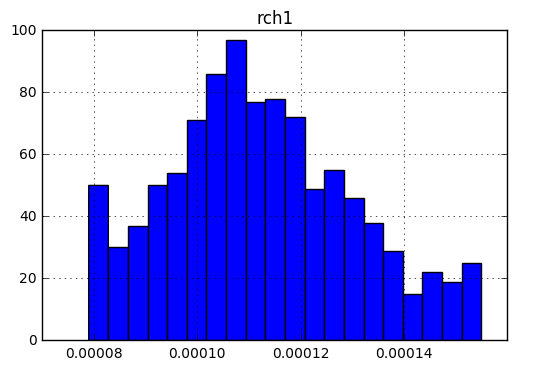

9.358508e-05 9.358508e-05 9.358508e-05


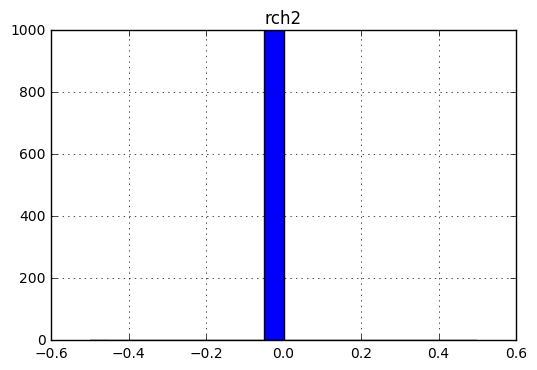

1.25 80.0 13.3993193414


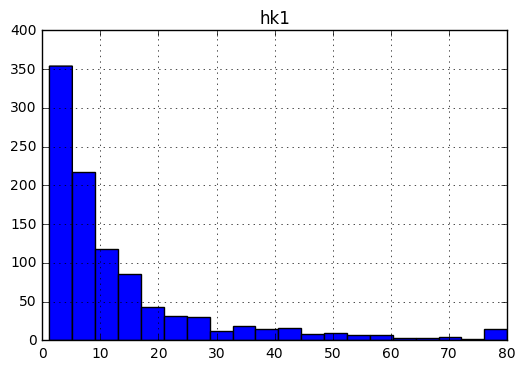

In [9]:
for pname in mc.pst.par_names:
    ax = mc.parensemble.loc[:,pname].hist(bins=20)
    print(mc.parensemble.loc[:,pname].min(),mc.parensemble.loc[:,pname].max(),mc.parensemble.loc[:,pname].mean())
    ax.set_title(pname)
    plt.show()
    

In [10]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


Do the log transformed parameters look like a log normal distribution?

Now we'll make the sweep file of runs to distribute (just like in the response surface notebooks)

In [12]:
mc.parensemble.to_csv("sweep_in.csv")

##  We are going to run the forward model 1000 times (!!!!) so it will take some time.  Watch the terminal window where you launched the notebook.  Wait for the 0 before going on.

In [13]:
pyemu.helpers.start_slaves(base_dir,"{0}sweep".format(pref),"freyberg.pst",num_slaves=20,master_dir='.')

## Alright - let's see some MC results.  For these runs, what was the Phi?

In [16]:
df_out = pd.read_csv("sweep_out.csv",index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.head()

,failed_flag,phi,meas_phi,regul_phi,TRAVEL_FORE,HEAD_FORE,FLUX_FORE,HEAD_CAL,FLUX_CAL,CR03C16,...,FR27C7,FR30C16,FR34C8,FR35C11,FR02C02,FR01C13,FR09C15,FR25C10,RIVFLUX_FORE,TRAVEL_TIME
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,193.513340,193.513340,0.0,0.0,0.0,0.0,193.513340,0.0,19.41591,...,16.52406,13.71104,15.07761,13.54750,22.91977,20.08570,1.797876e+01,15.71813,-2302.179,10513.51
1,0,187.294962,187.294962,0.0,0.0,0.0,0.0,187.294962,0.0,20.84807,...,25.10896,15.44503,19.86937,15.05777,36.25859,22.20053,-9.999999e+06,21.17462,-3187.615,49110.01
2,0,147.014473,147.014473,0.0,0.0,0.0,0.0,147.014473,0.0,19.44638,...,17.14229,13.82595,15.36389,13.59357,24.11286,20.22028,1.781488e+01,16.06678,-2076.453,14100.15
3,0,243.752260,243.752260,0.0,0.0,0.0,0.0,243.752260,0.0,19.34978,...,16.04311,13.66015,14.83863,13.46099,22.03527,19.99485,1.801190e+01,15.44618,-2006.522,9506.95
4,0,73.864692,73.864692,0.0,0.0,0.0,0.0,73.864692,0.0,19.56108,...,18.39821,14.03448,16.00553,13.77459,26.32843,20.49235,1.757457e+01,16.81017,-2172.951,18945.56


### Let's plot Phi

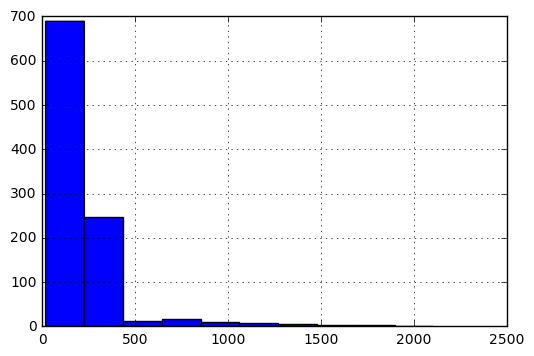

In [15]:
df_out.phi.hist()

### Wow, some of those models are really bad fits to the observations.  Those are not reasonable, so we should NOT include them in our uncertainty analysis.


# PAY ATTENTION:  this is super important - in this next block we are "conditioning" our Monte Carlo run by removing the bad runs. So here is the code where we are choosing which realizations we consider ``good enough`` with respect to fitting the observation data

In [17]:
acceptable_phi = 35.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[  7  16  35  37  51  63  76  80  81  82  98 103 105 109 111 112 114 134
 143 157 163 166 186 189 199 209 211 222 232 233 234 236 238 241 250 253
 264 267 268 270 285 286 289 302 305 310 323 330 343 354 365 379 386 387
 390 392 398 406 409 425 453 460 462 470 487 497 500 509 513 515 520 530
 536 542 558 561 565 575 584 585 601 603 606 619 624 654 655 686 688 689
 696 705 711 712 715 736 748 757 762 768 774 784 785 791 792 794 795 796
 801 803 814 822 831 833 854 856 859 861 863 873 874 880 892 898 903 908
 910 915 918 923 930 936 947 953 958 963 965 966 969 992 996]


#### So above is the list of run numbers that are meet our Phi cutoff

# Now the payoff - probablistic plots of our forecasts!s 

### Gray blocks show the range of the runs we threw out.  But those were considered within our bounds when we started, so those grey boxes represent our prior

### The blue boxes show the runs that met our criteria, so that distribution represents our posterior

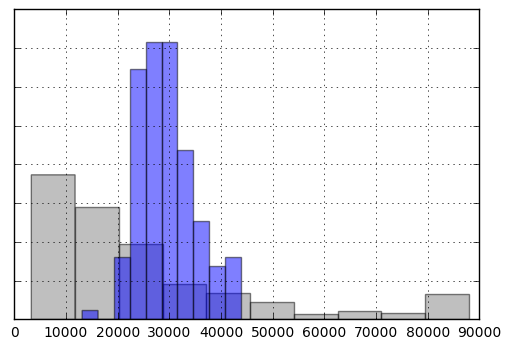

In [19]:
ax = df_out.TRAVEL_TIME.hist(alpha=0.5,color='0.5',normed=True)
ax.set_yticklabels([])
df_out.loc[good_enough,"TRAVEL_TIME"].hist(ax=ax,alpha=0.5,color='b',normed=True)

[]

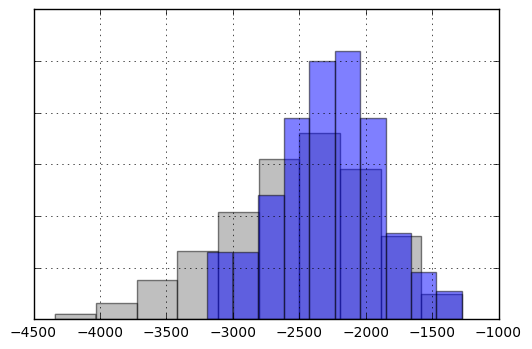

In [20]:
ax = df_out.RIVFLUX_FORE.hist(alpha=0.5,color="0.5",normed=True)
df_out.loc[good_enough,"RIVFLUX_FORE"].hist(ax=ax,color='b',alpha=0.5,normed=True)
ax.set_yticklabels([])

[]

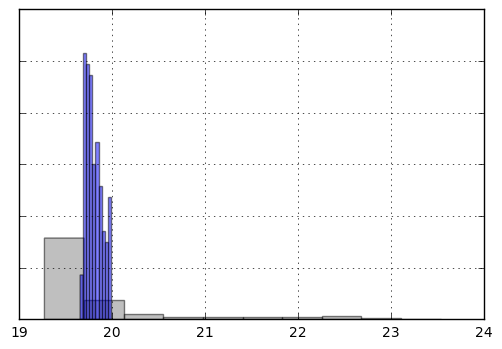

In [21]:
ax = df_out.FR03C16.hist(alpha=0.5,color="0.5",normed=True)
df_out.loc[good_enough,"FR03C16"].hist(ax=ax,color='b',alpha=0.5,normed=True)
ax.set_yticklabels([])

[]

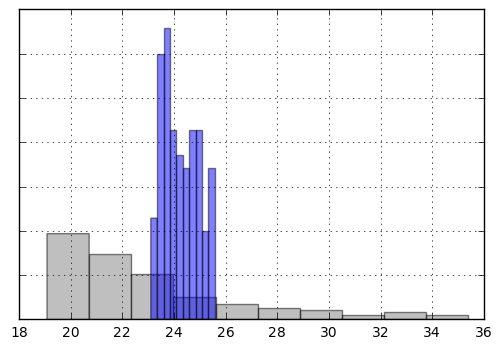

In [24]:
ax = df_out.FR04C9.hist(alpha=0.5,color="0.5",normed=True)
df_out.loc[good_enough,"FR04C9"].hist(ax=ax,color='b',alpha=0.5,normed=True)
ax.set_yticklabels([])

# What a power POWERFUL method to show our uncertainty, and what we learned from history matching.  Moreover, we are free of a lot of the limiting assumptions of FOSM.  

(What's the downside?)